In [46]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
"""
State Definitions and Pydantic Schemas for Research Agent

This module defines the state objects and structured schemas used for
the research agent workflow, including researcher state management and output schemas.
"""

import operator
from typing_extensions import TypedDict, Annotated, List, Sequence
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class ResearcherState(TypedDict):
    """
    State for the research agent containing message history and research metadata.
    
    This state tracks the researcher's conversation, iteration count for limiting
    tool calls, the research topic being investigated, compressed findings,
    and raw research notes for detailed analysis.
    """
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]
    # used to prevent too many tool calls, in this subagent
    tool_call_iterations: int
    research_topic: str
    # final result given back to the main agent
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]
    
class ResearcherOutputState(TypedDict):
    """
    Output state for the research agent containing final research results.
    
    This represents the final output of the research process with compressed
    research findings and all raw notes from the research process.
    """
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]

class ClarifyWithUser(BaseModel):
    """Schema for user clarification decisions during scoping phase."""
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )

class ResearchQuestion(BaseModel):
    """Schema for research brief generation."""
    research_brief: str = Field(
        description="A research question that will be used to guide the research.",
    )



In [48]:
"""Research Utilities and Tools.

This module provides search and content processing utilities for the research agent,
including web search capabilities and content summarization tools.
"""

from pathlib import Path
from datetime import datetime
from typing_extensions import Annotated, List, Literal

from langchain.chat_models import init_chat_model 
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool, InjectedToolArg
from tavily import TavilyClient

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

summarization_model = init_chat_model(model="openai:gpt-4.1-mini")
tavily_client = TavilyClient()

def tavily_search_multiple(
    search_queries: List[str], 
    max_results: int = 3, 
    topic: Literal["general", "news", "finance"] = "general", 
    include_raw_content: bool = True, 
) -> List[dict]:
    """Perform search using Tavily API for multiple queries.

    Args:
        search_queries: List of search queries to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        List of search result dictionaries
    """
    
    # Execute searches sequentially. Note: yon can use AsyncTavilyClient to parallelize this step.
    search_docs = []
    for query in search_queries:
        result = tavily_client.search(
            query,
            max_results=max_results,
            include_raw_content=include_raw_content,
            topic=topic
        )
        search_docs.append(result)

    return search_docs

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    summary: str = Field(description="Concise summary of the webpage content")
    key_excerpts: str = Field(description="Important quotes and excerpts from the content")

def summarize_webpage_content(webpage_content: str) -> str:
    """Summarize webpage content using the configured summarization model.
    
    Args:
        webpage_content: Raw webpage content to summarize
        
    Returns:
        Formatted summary with key excerpts
    """
    
    try:
      structured_model = summarization_model.with_structured_output(Summary)

      SUMMARIZE_WEBPAGE_PROMPT = """
      You are tasked with summarizing the raw content of a webpage retrieved from a web search. Your goal is to create a summary that preserves the most important information from the original web page. This summary will be used by a downstream research agent, so it's crucial to maintain the key details without losing essential information.

      Here is the raw content of the webpage:

      <webpage_content>
      {webpage_content}
      </webpage_content>

      Please follow these guidelines to create your summary:

      1. Identify and preserve the main topic or purpose of the webpage.
      2. Retain key facts, statistics, and data points that are central to the content's message.
      3. Keep important quotes from credible sources or experts.
      4. Maintain the chronological order of events if the content is time-sensitive or historical.
      5. Preserve any lists or step-by-step instructions if present.
      6. Include relevant dates, names, and locations that are crucial to understanding the content.
      7. Summarize lengthy explanations while keeping the core message intact.

      When handling different types of content:

      - For news articles: Focus on the who, what, when, where, why, and how.
      - For scientific content: Preserve methodology, results, and conclusions.
      - For opinion pieces: Maintain the main arguments and supporting points.
      - For product pages: Keep key features, specifications, and unique selling points.

      Your summary should be significantly shorter than the original content but comprehensive enough to stand alone as a source of information. Aim for about 25-30 percent of the original length, unless the content is already concise.

      Present your summary in the following format:

      ```
      {{
         "summary": "Your summary here, structured with appropriate paragraphs or bullet points as needed",
         "key_excerpts": "First important quote or excerpt, Second important quote or excerpt, Third important quote or excerpt, ...Add more excerpts as needed, up to a maximum of 5"
      }}
      ```

      Here are two examples of good summaries:

      Example 1 (for a news article):
      ```json
      {{
         "summary": "On July 15, 2023, NASA successfully launched the Artemis II mission from Kennedy Space Center. This marks the first crewed mission to the Moon since Apollo 17 in 1972. The four-person crew, led by Commander Jane Smith, will orbit the Moon for 10 days before returning to Earth. This mission is a crucial step in NASA's plans to establish a permanent human presence on the Moon by 2030.",
         "key_excerpts": "Artemis II represents a new era in space exploration, said NASA Administrator John Doe. The mission will test critical systems for future long-duration stays on the Moon, explained Lead Engineer Sarah Johnson. We're not just going back to the Moon, we're going forward to the Moon, Commander Jane Smith stated during the pre-launch press conference."
      }}
      ```

      Example 2 (for a scientific article):
      ```json
      {{
         "summary": "A new study published in Nature Climate Change reveals that global sea levels are rising faster than previously thought. Researchers analyzed satellite data from 1993 to 2022 and found that the rate of sea-level rise has accelerated by 0.08 mm/year² over the past three decades. This acceleration is primarily attributed to melting ice sheets in Greenland and Antarctica. The study projects that if current trends continue, global sea levels could rise by up to 2 meters by 2100, posing significant risks to coastal communities worldwide.",
         "key_excerpts": "Our findings indicate a clear acceleration in sea-level rise, which has significant implications for coastal planning and adaptation strategies, lead author Dr. Emily Brown stated. The rate of ice sheet melt in Greenland and Antarctica has tripled since the 1990s, the study reports. Without immediate and substantial reductions in greenhouse gas emissions, we are looking at potentially catastrophic sea-level rise by the end of this century, warned co-author Professor Michael Green."  
      }}
      ```

      Remember, your goal is to create a summary that can be easily understood and utilized by a downstream research agent while preserving the most critical information from the original webpage.

      Today's date is {date}.
      """
      
      response = structured_model.invoke([
        HumanMessage(content=SUMMARIZE_WEBPAGE_PROMPT.format(
          webpage_content=webpage_content,
          date=get_today_str()
        ))
      ])

      formatted_summary = (
        f"<summary>\n{response.summary}\n</summary>",
        f"<key_excerpts>\n{response.key_excerpts}\n</key_excerpts>"
      )

      return formatted_summary

    except Exception as e:
      print(f"Failed to summarize webpage: {str(e)}")
      return webpage_content[:1000] if len(webpage_content) > 100 else webpage_content
    
"""
search_results = [
  {
    "query": "Who is Leo Messi?",
    "answer": "Lionel Messi, born in 1987, is an Argentine footballer widely regarded as one of the greatest players of his generation. He spent the majority of his career playing for FC Barcelona, where he won numerous domestic league titles and UEFA Champions League titles. Messi is known for his exceptional dribbling skills, vision, and goal-scoring ability. He has won multiple FIFA Ballon d'Or awards, numerous La Liga titles with Barcelona, and holds the record for most goals scored in a calendar year. In 2014, he led Argentina to the World Cup final, and in 2015, he helped Barcelona capture another treble. Despite turning 36 in June, Messi remains highly influential in the sport.",
    "images": [],
    "results": [
      {
        "title": "Lionel Messi Facts | Britannica",
        "url": "https://www.britannica.com/facts/Lionel-Messi",
        "content": "Lionel Messi, an Argentine footballer, is widely regarded as one of the greatest football players of his generation. Born in 1987, Messi spent the majority of his career playing for Barcelona, where he won numerous domestic league titles and UEFA Champions League titles. Messi is known for his exceptional dribbling skills, vision, and goal",
        "score": 0.81025416,
        "raw_content": null,
        "favicon": "https://britannica.com/favicon.png"
      }
    ],
    "auto_parameters": {
      "topic": "general",
      "search_depth": "basic"
    },
    "response_time": "1.67",
    "request_id": "123e4567-e89b-12d3-a456-426614174111"
  },
  ....
]
"""
def deduplicate_search_results(search_results: List[dict]) -> dict:
    """Deduplicate search results by URL to avoid processing duplicate content.
    
    Args:
        search_results: List of search result dictionaries
        
    Returns:
        Dictionary mapping URLs to unique results
    """
    
    unique_results = {}
    
    for response in search_results:
      for result in response['results']:
        url = result['url']
        if url not in unique_results:
          unique_results[url] = result
    
    return unique_results
  

def process_search_results(unique_results: dict) -> dict:
    """Process search results by summarizing content where available.
    
    Args:
        unique_results: Dictionary of unique search results
        
    Returns:
        Dictionary of processed results with summaries
    """

    summarized_results = {}
    
    for url, result in unique_results.items():
      # use existing content if no raw content for summarization
      if not result.get('raw_content'):
        content = result['content']
      else:
        content = summarize_webpage_content(result['raw_content'])
      
      summarized_results[url] = {
        'title': result['title'],
        'content': content
      }
    
    return summarized_results

def format_search_output(summarized_results: dict) -> str:
    """Format search results into a well-structured string output.
    
    Args:
        summarized_results: Dictionary of processed search results
        
    Returns:
        Formatted string of search results with clear source separation
    """
    if not summarized_results:
        return "No valid search results found. Please try different search queries or use a different search API."
    
    formatted_output = "Search results: \n\n"
    
    for i, (url, result) in enumerate(summarized_results.items(), 1):
        formatted_output += f"\n\n--- SOURCE {i}: {result['title']} ---\n"
        formatted_output += f"URL: {url}\n\n"
        formatted_output += f"SUMMARY:\n{result['content']}\n\n"
        formatted_output += "-" * 80 + "\n"
    
    return formatted_output

@tool(parse_docstring=True)
def tavily_search_tool(
    query: str,
    max_results: Annotated[int, InjectedToolArg] = 3,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> str:
    """Fetch results from Tavily search API with content summarization.

    Args:
        query: A single search query to execute
        max_results: Maximum number of results to return
        topic: Topic to filter results by ('general', 'news', 'finance')

    Returns:
        Formatted string of search results with summaries
    """
    
    search_results = tavily_search_multiple(
      [query],
      max_results=max_results,
      topic=topic,
      include_raw_content=True
    )

    # dedup by url
    unique_results = deduplicate_search_results(search_results=search_results)
    
    # summarise results
    summarized_result = process_search_results(unique_results=unique_results)

    return format_search_output(summarized_results=summarized_result)

@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.
    
    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.
    
    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    
    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?
    
    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps
        
    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    return f"Reflection recorded: {reflection}"

In [49]:
"""Research Agent Implementation.

This module implements a research agent that can perform iterative web searches
and synthesis to answer complex research questions.
"""

from pydantic import BaseModel, Field
from typing_extensions import Literal

from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, filter_messages
from langchain.chat_models import init_chat_model


tools = [tavily_search_tool, think_tool]
tools_by_name = { tool.name: tool for tool in tools }

def llm_call_node(state: ResearcherState) -> ResearcherState:
    """Analyze current state and decide on next actions.
    
    The model analyzes the current conversation state and decides whether to:
    1. Call search tools to gather more information
    2. Provide a final answer based on gathered information
    
    Returns updated state with the model's response.
    """

    model = init_chat_model(model="openai:gpt-4.1-mini")
    model_with_tools = model.bind_tools(tools)
    
    RESEARCH_AGENT_PROMPT =  """
    You are a research assistant conducting research on the user's input topic. For context, today's date is {date}.

    <Task>
    Your job is to use tools to gather information about the user's input topic.
    You can use any of the tools provided to you to find resources that can help answer the research question. You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.
    </Task>

    <Available Tools>
    You have access to two main tools:
    1. **tavily_search**: For conducting web searches to gather information
    2. **think_tool**: For reflection and strategic planning during research

    **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**
    </Available Tools>

    <Instructions>
    Think like a human researcher with limited time. Follow these steps:

    1. **Read the question carefully** - What specific information does the user need?
    2. **Start with broader searches** - Use broad, comprehensive queries first
    3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?
    4. **Execute narrower searches as you gather information** - Fill in the gaps
    5. **Stop when you can answer confidently** - Don't keep searching for perfection
    </Instructions>

    <Hard Limits>
    **Tool Call Budgets** (Prevent excessive searching):
    - **Simple queries**: Use 2-3 search tool calls maximum
    - **Complex queries**: Use up to 5 search tool calls maximum
    - **Always stop**: After 5 search tool calls if you cannot find the right sources

    **Stop Immediately When**:
    - You can answer the user's question comprehensively
    - You have 3+ relevant examples/sources for the question
    - Your last 2 searches returned similar information
    </Hard Limits>

    <Show Your Thinking>
    After each search tool call, use think_tool to analyze the results:
    - What key information did I find?
    - What's missing?
    - Do I have enough to answer the question comprehensively?
    - Should I search more or provide my answer?
    </Show Your Thinking>
    """

    researcher_result = model_with_tools.invoke(
      [SystemMessage(content=RESEARCH_AGENT_PROMPT.format(date=get_today_str()))] + state["researcher_messages"]
    )

    return {
      "researcher_messages": [researcher_result]
    }

def tool_node(state: ResearcherState) -> ResearcherState:
    """Execute all tool calls from the previous LLM response.
    
    Executes all tool calls from the previous LLM responses.
    Returns updated state with tool execution results.
    """
    tool_calls = state["researcher_messages"][-1].tool_calls
    
    # Execute all tool calls & add it to observation
    observations = []
    for tool_call in tool_calls:
      tool = tools_by_name[tool_call['name']]
      observations.append(tool.invoke(tool_call["args"]))
      
    tool_outputs = [
      ToolMessage(
        content=observation,
        name=tool_call['name'],
        tool_call_id=tool_call['id']
      ) for observation, tool_call in zip(observations, tool_calls)
    ]
    
    return { 
            "researcher_messages": tool_outputs,
            "tool_call_iterations": len(tool_outputs)
          }

def compress_research_node(state: ResearcherState) -> ResearcherState:
    """Compress research findings into a concise summary.
    
    Takes all the research messages and tool outputs and creates
    a compressed summary suitable for the supervisor's decision-making.
    """
    COMPRESS_RESEARCH_SYSTEM_PROMPT = """You are a research assistant that has conducted research on a topic by calling several tools and web searches. Your job is now to clean up the findings, but preserve all of the relevant statements and information that the researcher has gathered. For context, today's date is {date}.

    <Task>
    You need to clean up information gathered from tool calls and web searches in the existing messages.
    All relevant information should be repeated and rewritten verbatim, but in a cleaner format.
    The purpose of this step is just to remove any obviously irrelevant or duplicate information.
    For example, if three sources all say "X", you could say "These three sources all stated X".
    Only these fully comprehensive cleaned findings are going to be returned to the user, so it's crucial that you don't lose any information from the raw messages.
    </Task>

    <Tool Call Filtering>
    **IMPORTANT**: When processing the research messages, focus only on substantive research content:
    - **Include**: All tavily_search results and findings from web searches
    - **Exclude**: think_tool calls and responses - these are internal agent reflections for decision-making and should not be included in the final research report
    - **Focus on**: Actual information gathered from external sources, not the agent's internal reasoning process

    The think_tool calls contain strategic reflections and decision-making notes that are internal to the research process but do not contain factual information that should be preserved in the final report.
    </Tool Call Filtering>

    <Guidelines>
    1. Your output findings should be fully comprehensive and include ALL of the information and sources that the researcher has gathered from tool calls and web searches. It is expected that you repeat key information verbatim.
    2. This report can be as long as necessary to return ALL of the information that the researcher has gathered.
    3. In your report, you should return inline citations for each source that the researcher found.
    4. You should include a "Sources" section at the end of the report that lists all of the sources the researcher found with corresponding citations, cited against statements in the report.
    5. Make sure to include ALL of the sources that the researcher gathered in the report, and how they were used to answer the question!
    6. It's really important not to lose any sources. A later LLM will be used to merge this report with others, so having all of the sources is critical.
    </Guidelines>

    <Output Format>
    The report should be structured like this:
    **List of Queries and Tool Calls Made**
    **Fully Comprehensive Findings**
    **List of All Relevant Sources (with citations in the report)**
    </Output Format>

    <Citation Rules>
    - Assign each unique URL a single citation number in your text
    - End with ### Sources that lists each source with corresponding numbers
    - IMPORTANT: Number sources sequentially without gaps (1,2,3,4...) in the final list regardless of which sources you choose
    - Example format:
      [1] Source Title: URL
      [2] Source Title: URL
    </Citation Rules>

    Critical Reminder: It is extremely important that any information that is even remotely relevant to the user's research topic is preserved verbatim (e.g. don't rewrite it, don't summarize it, don't paraphrase it).
    """

    system_message = [SystemMessage(content=COMPRESS_RESEARCH_SYSTEM_PROMPT.format(date=get_today_str()))]

    # @note - research_topic is NOT used
    COMPRESS_RESEARCH_HUMAN_MESSAGE = """
    All above messages are about research conducted by an AI Researcher for the following research topic:

    RESEARCH TOPIC: {research_topic}

    Your task is to clean up these research findings while preserving ALL information that is relevant to answering this specific research question. 

    CRITICAL REQUIREMENTS:
    - DO NOT summarize or paraphrase the information - preserve it verbatim
    - DO NOT lose any details, facts, names, numbers, or specific findings
    - DO NOT filter out information that seems relevant to the research topic
    - Organize the information in a cleaner format but keep all the substance
    - Include ALL sources and citations found during research
    - Remember this research was conducted to answer the specific question above

    The cleaned findings will be used for final report generation, so comprehensiveness is critical."""

    human_message = [HumanMessage(content=COMPRESS_RESEARCH_HUMAN_MESSAGE)]
    
    compress_model = init_chat_model(model="openai:gpt-4.1", max_tokens=32000)
    messages = system_message + state.get('researcher_messages', []) + human_message
    response = compress_model.invoke(messages)
    
    raw_notes = [
      str(m.content) for m in filter_messages(
        messages=state["researcher_messages"],
        include_types=["tool", "ai"]
      )
    ]

    return {
      "compressed_research": str(response.content),
      "raw_notes": ["\n".join(raw_notes)]
    }

def should_continue(state: ResearcherState) -> Literal["tool_node", "compress_research"]:
    """Determine whether to continue research or provide final answer.
    
    Determines whether the agent should continue the research loop or provide
    a final answer based on whether the LLM made tool calls.
    
    Returns:
        "tool_node": Continue to tool execution
        "compress_research": Stop and compress research
    """
    messages = state["researcher_messages"]
    last_message = messages[-1]
    
    # If the LLM makes a tool call, continue to tool execution
    if last_message.tool_calls:
        return "tool_node"
    # Otherwise, we have a final answer
    return "compress_research"

agent_builder = StateGraph(ResearcherState, output_schema=ResearcherOutputState)

agent_builder.add_node("llm_call", llm_call_node)
agent_builder.add_node("tool_node", tool_node)
agent_builder.add_node("compress_research", compress_research_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_node": "tool_node", # Continue research loop
        "compress_research": "compress_research", # Provide final answer
    },
)
agent_builder.add_edge("tool_node", "llm_call") # Loop back for more research
agent_builder.add_edge("compress_research", END)

# Compile the agent
researcher_agent = agent_builder.compile()


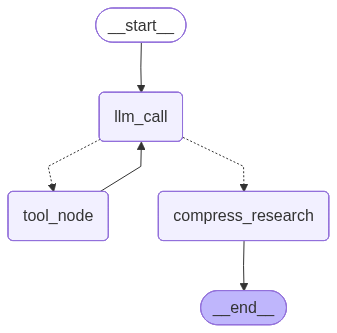

In [50]:
from IPython.display import Image, display

# Show the agent
display(Image(researcher_agent.get_graph(xray=True).draw_mermaid_png()))

In [51]:
# Run the agent
from utils import format_messages
from langchain_core.messages import HumanMessage

# Example brief
RESEARCH_BRIEF = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

result = researcher_agent.invoke({"researcher_messages": [HumanMessage(content=f"{RESEARCH_BRIEF}.")]})
format_messages(result['researcher_messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to identify and evaluate the coffee shops in San Francisco that are considered the best based            │
│ specifically                                                                                                    │
│ on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco    │
│ area,                                                                                                           │
│ using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,   │
│ expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,   │
│ location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary │
│ sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like  │
│ Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where      │
│ direct                                                                                                          │
│ customer feedback about coffee quality can be found. The study should result in a well-supported list or        │
│ ranking of                                                                                                      │
│ the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data  │
│ as                                                                                                              │
│ of July 2025..                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search_tool                                                                                │
│    Args: {                                                                                                      │
│   "query": "best coffee shops in San Francisco based on coffee quality expert reviews customer ratings          │
│ specialty coffee certifications 2025"                                                                           │
│ }                                                                                                               │
│    ID: call_eWeOxVVfD9csOClmvmbYrLyY                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: I tried EVERY Coffee Shops in San Francisco. Here are the TOP 16 ---                              │
│ URL: https://www.youtube.com/watch?v=xvTYaECZFbk                                                                │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ ("<summary>\nThe webpage is a comprehensive guide to 16 top coffee shops in San Francisco, curated by Navigate  │
│ with Kate. Posted on April 13, 2025, the guide categorizes these coffee spots into sections such as             │
│ work-friendly cafés, best roasters, uniquely designed shops, and the top five specialty coffee shops. Notable   │
│ mentions include Blue Bottle Coffee, known for its iconic presence and work-friendly environment; Bluestone     │
│ Lane, which offers Australian-inspired coffee and quality food; Andytown Coffee and Equator Coffees for good    │
│ ambiance; and Flywheel Coffee Roasters with unique brewing options. Best roasters highlighted are Linea Coffee  │
│ Roasters, Sextant Coffee Roasters, and Ritual Coffee Roasters. The design and unique category features P-Town   │
│ Coffee, a café with notable design, Transamerica Pyramid lobby coffee spot, and Post Script Coffee, which       │
│ doubles as a high-end grocery. The top five specialty coffee shops identified for their exceptional coffee are  │
│ The Coffee Movement, Moaring Coffee, Paper Moon Coffee, Saint Frank Coffee, and The Mill, the latter being      │
│ praised for its excellent coffee and delicious bread and toasts. The guide also provides insights into each     │
│ location's ambiance, coffee quality, design, and suitability for work or leisure, making it a valuable resource │
│ for coffee lovers and visitors seeking diverse experiences in San Francisco's coffee culture.\n</summary>",     │
│ '<key_excerpts>\nBlue Bottle coffee is a quintessential San Francisco success story from a humble cart to over  │
│ 70 locations. Bluestone Lane, Australian-inspired, excels in food offerings though the coffee was less favored. │
│ Flywheel Roasters is known for unique brewing like siphon coffee. Ritual Coffee Roasters is ideal for sunny     │
│ days with neighborhood vibes. Post Script Coffee combines high-end grocery with specialty coffee. The Coffee    │
│ Movement offers coffee near the Cable Car Museum with limited seating but great views. Moaring Coffee features  │
│ automotive-themed decor with a club for car enthusiasts. Paper Moon Coffee offers unique tea-like coffee        │
│ flavors and a conducive work environment. Saint Frank Coffee provides a flight set tasting perfect for coffee   │
│ enthusiasts. The Mill gains fame not only for coffee but for its popular bread and toasts.\n</key_excerpts>')   │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2: Best Coffee San Francisco, CA - Last Upda

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "From the first search, I gathered a list of top coffee shops in San Francisco based mainly on  │
│ coffee quality from different sources including expert and customer reviews: notable mentions are Blue Bottle   │
│ Coffee, Ritual Coffee Roasters, Saint Frank Coffee, Sextant Coffee Roasters, The Coffee Movement, Moaring       │
│ Coffee, Paper Moon Coffee, The Mill, Q Specialty Coffee, Hedge Coffee Roasters, and others. The sources provide │
│ a mix of expert opinion and customer feedback, with some mentioning unique coffee brewing methods, flight       │
│ tastings, and specialty coffee standards. However, the summaries currently mainly provide names and qualitative │
│ descriptions, but lack direct coffee quality ratings, certification status, or aggregated numerical             │
│ scores.\n\nWhat's missing: More specific data on coffee quality such as ratings from reputable third-party      │
│ coffee review organizations, specialty coffee certifications, detailed customer rating breakdowns specifically  │
│ related to coffee quality rather than ambiance or food, and any recent brand updates as of July 2025.\n\nNext   │
│ steps: I should conduct more focused searches targeting reputed coffee review sites (e.g., Coffee Review,       │
│ Specialty Coffee Association) for San Francisco coffee shops, and also extract relevant customer rating data    │
│ focusing exclusively on coffee quality from sources like Google Reviews or Yelp with filters or keywords to     │
│ isolate coffee quality feedback from other variables."                                                          │
│ }                                                                                                               │
│    ID: call_56WWLB8VGdPcBIxSFWdpspZA                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: From the first search, I gathered a list of top coffee shops in San Francisco based mainly │
│ on coffee quality from different sources including expert and customer reviews: notable mentions are Blue       │
│ Bottle Coffee, Ritual Coffee Roasters, Saint Frank Coffee, Sextant Coffee Roasters, The Coffee Movement,        │
│ Moaring Coffee, Paper Moon Coffee, The Mill, Q Specialty Coffee, Hedge Coffee Roasters, and others. The sources │
│ provide a mix of expert opinion and customer feedback, with some mentioning unique coffee brewing methods,      │
│ flight tastings, and specialty coffee standards. However, the summaries currently mainly provide names and      │
│ qualitative descriptions, but lack direct coffee quality ratings, certification status, or aggregated numerical │
│ scores.                                                                                                         │
│                                                                                                                 │
│ What's missing: More specific data on coffee quality such as ratings from reputable third-party coffee review   │
│ organizations, specialty coffee certifications, detailed customer rating breakdowns specifically related to     │
│ coffee quality rather than ambiance or food, and any recent brand updates as of July 2025.                      │
│                                                                                                                 │
│ Next steps: I should conduct more focused searches targeting reputed coffee review sites (e.g., Coffee Review,  │
│ Specialty Coffee Association) for San Francisco coffee shops, and also extract relevant customer rating data    │
│ focusing exclusively on coffee quality from sources like Google Reviews or Yelp with filters or keywords to     │
│ isolate coffee quality feedback from other variables.                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search_tool                                                                                │
│    Args: {                                                                                                      │
│   "query": "San Francisco coffee shops coffee quality ratings site:coffeereview.com 2025"                       │
│ }                                                                                                               │
│    ID: call_VGS6hqYZFF1HTGBwE2ohkJKz                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search_tool                                                                                │
│    Args: {                                                                                                      │
│   "query": "San Francisco coffee shops specialty coffee certifications 2025"                                    │
│ }                                                                                                               │
│    ID: call_vZTkiPr2VRAgEJ5jNQo2HCif                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search_tool                                                                                │
│    Args: {                                                                                                      │
│   "query": "San Francisco coffee shops coffee quality customer reviews site:yelp.com 2025"                      │
│ }                                                                                                               │
│    ID: call_4QOUs24KskTcnzkzjABmLjAx                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: Organic Rainforest Blend by San Francisco Bay Coffee ---                                          │
│ URL: https://www.coffeereview.com/review/organic-rainforest-blend/                                              │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ ("<summary>\nThe webpage presents a detailed review of the Organic Rainforest Blend coffee by San Francisco Bay │
│ Coffee (Costco), roasted in Lincoln, California. This very dark roast (Agtron 29/35) is certified organic and   │
│ was purchased as whole beans for about $5.65 per pound. The tasting review, conducted in November 2012 by       │
│ Kenneth Davids of Coffee Review, describes the coffee's aroma and flavor as dominated by heavily scorched wood  │
│ notes with hints of faded chocolate, clove, and molasses. The acidity is subdued within a strong roasted        │
│ pungency, and the mouthfeel is light and lean, finishing bittersweet and drying. This coffee is recommended for │
│ lovers of ultra-dark “French” roasts who also appreciate organic cultivation at an affordable price point.      │
│ Additional resources include more reviews from San Francisco Bay Coffee and background on Kenneth Davids, the   │
│ editor and co-founder of Coffee Review, known for his authoritative work on specialty coffee since the          │
│ 1970s.\n</summary>", '<key_excerpts>\nHeavily scorched wood dominates in aroma and cup, with hints of faded     │
│ chocolate, clove and molasses., Acidity is folded inside the scorched pungency of the roast; mouthfeel is light │
│ and leanish., Lovers of ultra-dark “French” roasts and organic agriculture. A little more flavor nuance at      │
│ considerably less money than offered by most such super-dark blends, organic or otherwise., San Francisco Bay   │
│ is one of five coffee brands produced by the family-owned Rogers Family Company., Kenneth Davids is editor,     │
│ chief writer and co-founder of Coffee Review with decades of experience in specialty coffee.\n</key_excerpts>') │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2: Organic Fair Trade Sumatra Gayoland ---                                                           │
│ URL: https://www.coffeereview.com/review/organic-fair-trade-sumatra-gayoland/                                   │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ ('<summary>\nCoffee Review is the world\'s leading coffee guide, providing detailed reviews and ratings of      │
│ specialty coffees. The webpage features various advertisements and links to top-rated coffee roasters and       │
│ sellers such as Durango Coffee Company, Hula Daddy, Bar

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: Coffee Nerds and Matcha Stans Will Love This Pac Heights Cafe ---                                 │
│ URL: https://sf.eater.com/restaurant-news/208595/q-specialty-coffee-opening-pac-heights                         │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ ("<summary>\nQ Specialty Coffee, a new cafe located on the cusp of Laurel Heights and Pacific Heights in San    │
│ Francisco, is set to open on Saturday, October 18, 2025. Founded by Cyrus Shen, an experienced restaurateur and │
│ coffee aficionado certified by Bay Area coffee expert Willem Boot, the cafe offers a menu focused on specialty  │
│ coffee trends and deep coffee expertise. The cafe features seasonal single-origin pourover coffees with         │
│ detailed tasting notes and bean provenance, made with a Poursteady PS1 automated pourover machine. Initial      │
│ offerings include a washed Honduras-grown La Avi coffee with a cup score of 92. The menu also includes          │
│ innovative drinks such as chai lattes with espresso cloud toppers, five specialty matcha drinks including       │
│ triple matcha cloud and sparkling lime matcha cloud, and nitro cold brew paired with fruit flavors like guava   │
│ and jasmine tea. Q Specialty Coffee emphasizes transparency and storytelling in coffee, featuring on-site       │
│ roasting with two Bellwether roasters, allowing customers to see and smell beans and purchase them by the       │
│ pound. The cafe's design adheres to third wave coffee aesthetics inspired by venues like The Barn in Berlin,    │
│ combining clean design with educational displays such as scent beakers and tubing. Shen plans to open two more  │
│ Q Specialty Coffee locations in San Francisco before expanding further. The cafe will operate daily from 6 a.m. │
│ to 6 p.m. at 3490 California Street.\n</summary>", '<key_excerpts>\n"We believe it has the potential to become  │
│ one of the top coffee destinations in the city," Shen says, "not enough places in San Francisco ... care about  │
│ the story behind the beans and the cafe experience." "Those seasonal pourovers will rotate in and out of the    │
│ cafe; to start, there’s a washed Honduras-grown La Avi — a blend of bourbon, catui, and lempia varietals — with │
│ tasting notes of caramel and apple cobbler. It has a cup score of 92, per the menu." "There are also five       │
│ specialty matcha drinks, including a triple matcha cloud, or cold foam, relying on three uses of the green tea  │
│ and a sparkling lime matcha cloud introducing a carbonated Topo Chico-esque backbone." "Following trends in     │
│ Japan and Southeast Asia, Shen has a suite of green beans and roasting tech on-site. That includes two brand    │
│ new Bellwether roasters. Guests can look at and smell the beans ... when they’re roasted, and then purchase     │
│ them by the pound."\n</key_excerpts>')                                                                          │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                        

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: SIGHTGLASS COFFEE - Updated November 2025 ---                                                     │
│ URL: https://www.yelp.com/biz/sightglass-coffee-san-francisco-7                                                 │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ ('<summary>\nSightglass Coffee is a well-known coffee roastery located at 270 Seventh St, San Francisco, CA     │
│ 94103, operating mainly in the SoMa neighborhood. It is recognized for its craft, small-batch, single-origin    │
│ coffee selections that emphasize quality and integrity in sourcing, harvesting, roasting, and brewing. Open     │
│ daily with hours from 6:30 AM or 7:00 AM until 5:00 PM, Sightglass attracts a loyal following and has a         │
│ 4.0-star rating from over 2,100 Yelp reviews. The space is described as industrial, spacious with an upstairs   │
│ and downstairs area, featuring large windows, natural light, and tall ceilings. Visitors appreciate the quality │
│ of coffee, the variety of drinks including Vanilla Cold Brew, Matcha Latte, and unique items like the Brown     │
│ Butter Miso Caramel Latte and Sea Salt Caramel Affogato. The shop offers pastries such as almond financier,     │
│ chocolate croissants, and unique breakfast options like breakfast burritos. The establishment is popular as a   │
│ study and work spot, particularly on the upstairs floor, though it currently does not provide WiFi or power     │
│ outlets for device charging. Patrons note a friendly staff, a dog-friendly atmosphere, and a busy, lively       │
│ environment especially on weekends, with some waiting times for drinks during peak hours. Sightglass also       │
│ provides roasting classes and sells bags of freshly roasted beans both in-store and online. The business        │
│ manager, Anthony F., is active in responding to customer reviews and queries, showing engagement with the       │
│ community.\n</summary>', "<key_excerpts>\nKnown for its craft small-batch, single-origin selections, Sightglass │
│ has garnered a loyal following for its pristine coffee that is thoughtfully sourced, harvested, roasted and     │
│ brewed to preserve the integrity of the beans., I can always count on this place to snap me out of being a      │
│ morning zombie every Saturday!, This spot is a great place to catch up with old friends, cute coffee date, or   │
│ to study and plan your next big adventures!, Sightglass coffee is a dope coffee spot, I love the industrial     │
│ vibes and the fact that you can see the operations running while you drink the product., They have roasting     │
│ classes (!!!) and if I lived in town I'd go.\n</key_excerpts>")                                                 │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2: Coffee Shops 145 Hooper St, San Francisco

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The recent parallel search results provide some deeper insights:\n\n1. From Coffee Review      │
│ (primary source), some San Francisco-related roasters like San Francisco Bay Coffee and Capricorn Coffees have  │
│ detailed coffee reviews and ratings, focusing on blends or single-origin coffees. However, these are mostly     │
│ roasters rather than cafes, and some reviews are older. No explicit coffee quality rankings for cafes, but      │
│ these reviews establish a solid expert baseline.\n\n2. More detailed recent info about cafes like Q Specialty   │
│ Coffee (opened 2025, with a high-scoring single-origin coffee cup score of 92) indicates an emphasis on coffee  │
│ quality and roasting transparency. Andytown Coffee shows commitment to quality through sourcing, roasting, and  │
│ skilled baristas.\n\n3. Yelp reviews show that high-quality shops like Sightglass Coffee hold a strong          │
│ reputation (4.0+ stars with many reviews) with customer praises for coffee quality and specialty                │
│ drinks.\n\nWhat's missing:\n- Consolidated expert coffee quality ratings specifically ranking SF coffee         │
│ shops.\n- Specialty Coffee Association certification data for SF cafes.\n- More customer review data            │
│ specifically isolating coffee quality (not just ambiance or food).\n\nNext step:\n- Search Specialty Coffee     │
│ Association certified shops in San Francisco.\n- Search Google Reviews average coffee quality ratings or        │
│ keywords for top shops to validate customer sentiment.\n- Look for any curated rankings focused solely on       │
│ coffee quality from reputable reviewers or organizations published in 2025."                                    │
│ }                                                                                                               │
│    ID: call_MadQSwmpPEC8ZF7HfwSPFytP                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The recent parallel search results provide some deeper insights:                           │
│                                                                                                                 │
│ 1. From Coffee Review (primary source), some San Francisco-related roasters like San Francisco Bay Coffee and   │
│ Capricorn Coffees have detailed coffee reviews and ratings, focusing on blends or single-origin coffees.        │
│ However, these are mostly roasters rather than cafes, and some reviews are older. No explicit coffee quality    │
│ rankings for cafes, but these reviews establish a solid expert baseline.                                        │
│                                                                                                                 │
│ 2. More detailed recent info about cafes like Q Specialty Coffee (opened 2025, with a high-scoring              │
│ single-origin coffee cup score of 92) indicates an emphasis on coffee quality and roasting transparency.        │
│ Andytown Coffee shows commitment to quality through sourcing, roasting, and skilled baristas.                   │
│                                                                                                                 │
│ 3. Yelp reviews show that high-quality shops like Sightglass Coffee hold a strong reputation (4.0+ stars with   │
│ many reviews) with customer praises for coffee quality and specialty drinks.                                    │
│                                                                                                                 │
│ What's missing:                                                                                                 │
│ - Consolidated expert coffee quality ratings specifically ranking SF coffee shops.                              │
│ - Specialty Coffee Association certification data for SF cafes.                                                 │
│ - More customer review data specifically isolating coffee quality (not just ambiance or food).                  │
│                                                                                                                 │
│ Next step:                                                                                                      │
│ - Search Specialty Coffee Association certified shops in San Francisco.                                         │
│ - Search Google Reviews average coffee quality ratings or keywords for top shops to validate customer           │
│ sentiment.                                                                                                      │
│ - Look for any curated rankings focused solely on coffee quality from reputable reviewers or organizations      │
│ published in 2025.                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search_tool                                                                                │
│    Args: {                                                                                                      │
│   "query": "Specialty Coffee Association certified coffee shops San Francisco 2025"                             │
│ }                                                                                                               │
│    ID: call_TDX3pcSwFojLQQFNBlELIEHS                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search_tool                                                                                │
│    Args: {                                                                                                      │
│   "query": "top San Francisco coffee shops customer reviews coffee quality site:google.com 2025"                │
│ }                                                                                                               │
│    ID: call_zWzOdyOwl1sA7xAPFkYPfYxe                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search_tool                                                                                │
│    Args: {                                                                                                      │
│   "query": "best coffee shops ranking San Francisco coffee quality expert reviews 2025"                         │
│ }                                                                                                               │
│    ID: call_txiL0g2S7BN2qGru3iw2pHQK                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: Specialty Coffee Association ---                                                                  │
│ URL: https://sca.coffee/                                                                                        │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ ('<summary>\nThe Specialty Coffee Association (SCA) is the largest global coffee trade association, committed   │
│ to improving specialty coffee through community building, education, research, standards, and events worldwide. │
│ Key upcoming events include the 25th World Barista Championship in Milan (October 17-21, 2025), the fifth       │
│ anniversary World of Coffee shows in Dubai (January 18-20, 2026), North America in San Diego (April 10-12,      │
│ 2026), Asia in Bangkok (May 7-9, 2026), Brussels debut (June 25-27, 2026), and the first Latin American World   │
│ of Coffee trade show in Panama (October 23-25, 2026). The SCA emphasizes sustainability and equitable value     │
│ distribution throughout the coffee supply chain via initiatives like the Coffee Value Assessment tool.          │
│ Education offerings include SCA Skills Diplomas, the Q Grader Program for sensory and coffee evaluation, and    │
│ programs to become certified educators globally. Recent research highlights inequitable value distribution as a │
│ root cause of the 2018 price crisis and introduces the Coffee Systems Map outlining industry ecosystem          │
│ relationships. The latest community impact survey report, Read 25, focuses on airborne disease transmission in  │
│ coffee businesses, offering safety strategies. The SCA continues to foster global coffee industry development   │
│ through these programs and resources.\n</summary>', '<key_excerpts>\nThe Specialty Coffee Association (SCA) is  │
│ the largest global coffee trade association dedicated to making coffee better by fostering a global coffee      │
│ community and supporting activities to make specialty coffee a thriving, equitable, and sustainable endeavor    │
│ for the entire value chain., 2025 marks a remarkable milestone for the World Barista Championship (WBC) as it   │
│ proudly celebrates its 25th edition., Driven by the SCA’s sustainability agenda, which emphasizes equitable     │
│ value distribution throughout the supply chain, the system aspires to be a powerful tool to help measure and    │
│ facilitate value assessment and distribution., The Q Grader Program is specialty coffee’s leading license for   │
│ professionals, encompassing cupping, sensory analysis, and green coffee evaluation., Identifying inequitable    │
│ value distribution as a key root cause of the 2018 price crisis, the summary of work highlights opportunities   │
│ to work towards a more equitable specialty coffee industry.\n</key_excerpts>')                                  │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                        

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: User intent and context based search results ---                                                  │
│ URL: https://patents.google.com/patent/WO2017143338A1/en                                                        │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ • U> Coffee near my house. • A> OK. Here are the best coffee shops in San Francisco: • A> [Agent presents       │
│ carousel of coffee shops]. • A> What                                                                            │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2: Backlinks: Why They Still Matter and How to Build Them ---                                        │
│ URL: https://feedproxy.google.com/~r/VerticalresponseEmailMarketingBlog/~3/BUdSDCy6YXg/                         │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ Stumptown: We really love coffee in San Francisco and Stumptown out of Portland, Oregon is among our favorites. │
│ Stumptown Coffee often                                                                                          │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 3: Trailblazing SF coffee chain sold to private equity firm for ... ---                              │
│ URL: https://www.google.com/share.google?q=hpMIA0Uly4FyM8fM3                                                    │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ Freeman Spogli and Co., a private equity firm that has invested in Popeyes and Petco, has purchased Philz       │
│ Coffee.                                                                                                         │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
╰────────────────────────────────────────────────────────

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: I tried EVERY Coffee Shops in San Francisco. Here are the TOP 16 ---                              │
│ URL: https://www.youtube.com/watch?v=xvTYaECZFbk                                                                │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ ("<summary>\nThe webpage presents a comprehensive guide to 16 top coffee shops in San Francisco, curated by     │
│ Navigate with Kate. It categorizes these cafés into four main groups: work-friendly spots, best roasters,       │
│ uniquely designed coffee shops, and top specialty coffee shops. Key work-friendly locations include Blue Bottle │
│ Coffee, Bluestone Lane, Andytown Coffee, Equator Coffees, and Flywheel Coffee Roasters. Prominent roasters      │
│ featured are Linea Coffee Roasters, Sextant Coffee Roasters, and Ritual Coffee Roasters. Unique and             │
│ design-focused shops include P-Town Coffee, a café inside the Transamerica Pyramid, and Post Script Coffee. The │
│ top five specialty coffee shops selected for exceptional taste and atmosphere are The Coffee Movement, Moaring  │
│ Coffee (notable for its automobile-themed design and car club), Paper Moon Coffee, Saint Frank Coffee, and The  │
│ Mill—renowned for its excellent coffee and especially its artisanal bread and toasts. The guide emphasizes both │
│ coffee quality and ambiance, catering to various preferences, from casual work sessions to specialty coffee     │
│ connoisseurs. The content includes practical information about each shop's atmosphere, design, coffee           │
│ offerings, and suitable activities (e.g., working, enjoying scenic views, tasting unique brews). The guide is   │
│ structured with timestamps and chapters for easy navigation and highlights the vibrant coffee culture of San    │
│ Francisco as of April 2025.\n</summary>", '<key_excerpts>\n"San Francisco is a coffee lover\'s paradise, and    │
│ this guide highlights 16 must-try coffee spots to satisfy every craving!", "Blue Bottle Coffee ... offers an    │
│ excellent environment for work but its interior design is also a visual delight.", "Flywheel Roasters stands    │
│ out for its unique brewing options like siphon coffee and since they\'re a roaster you can grab some of their   │
│ beans to take home.", "Post Script Coffee ... not just a coffee shop though, it\'s also a high-end grocery      │
│ store with a few select items like cheeses, olive oils, and other specialty products.", "The Mill ... famous    │
│ for their delicious bread and toasts they make with it; it\'s one of our top spots on the San Francisco brunch  │
│ list.", "Moaring Coffee ... one of their tables is actually a car turned into a seating area and in the back    │
│ there is even a separate section that is reserved for club members featuring some unique car                    │
│ models."\n</key_excerpts>')                                                                                     │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The third batch of searches revealed these key points:\n\n1. Specialty Coffee Association      │
│ (SCA) information was broad and didn't list specific San Francisco coffee shops certified by the SCA directly,  │
│ but it highlighted their programs like Q Grader and certifications related to sensory evaluation and coffee     │
│ quality standards.\n\n2. Google search and other reviews included some curated rankings focused on coffee       │
│ quality, especially the 2025 guide by Damian on \"Best Coffee Shops in San Francisco\". This ranks Saint Frank  │
│ Coffee highest based on coffee quality (espresso and cappuccino rated 8.5/10) alongside detailed customer       │
│ insights.\n\n3. Eater SF's 2025 list validated top shops with a coffee quality focus, adding Q Specialty        │
│ Coffee, Hedge Coffee Roasters, and others to the elite list, providing qualitative descriptions of coffee       │
│ excellence.\n\n4. Yelp customer ratings for some shops like Sightglass Coffee supported strong reputation for   │
│ coffee quality.\n\n5. Missing consolidated certification or explicit SCA-certified shop listings for San        │
│ Francisco, but multiple credible sources (expert bloggers, recognized media outlets) converge on a core list of │
│ highly recommended coffee shops emphasizing quality.\n\nNext step is to synthesize these findings into a        │
│ well-supported ranking focusing on coffee quality per user request, highlighting expert ratings, customer       │
│ feedback, and any relevant certifications or known distinctions."                                               │
│ }                                                                                                               │
│    ID: call_yAcg1CnfzedAbnt4lhSmrEEP                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The third batch of searches revealed these key points:                                     │
│                                                                                                                 │
│ 1. Specialty Coffee Association (SCA) information was broad and didn't list specific San Francisco coffee shops │
│ certified by the SCA directly, but it highlighted their programs like Q Grader and certifications related to    │
│ sensory evaluation and coffee quality standards.                                                                │
│                                                                                                                 │
│ 2. Google search and other reviews included some curated rankings focused on coffee quality, especially the     │
│ 2025 guide by Damian on "Best Coffee Shops in San Francisco". This ranks Saint Frank Coffee highest based on    │
│ coffee quality (espresso and cappuccino rated 8.5/10) alongside detailed customer insights.                     │
│                                                                                                                 │
│ 3. Eater SF's 2025 list validated top shops with a coffee quality focus, adding Q Specialty Coffee, Hedge       │
│ Coffee Roasters, and others to the elite list, providing qualitative descriptions of coffee excellence.         │
│                                                                                                                 │
│ 4. Yelp customer ratings for some shops like Sightglass Coffee supported strong reputation for coffee quality.  │
│                                                                                                                 │
│ 5. Missing consolidated certification or explicit SCA-certified shop listings for San Francisco, but multiple   │
│ credible sources (expert bloggers, recognized media outlets) converge on a core list of highly recommended      │
│ coffee shops emphasizing quality.                                                                               │
│                                                                                                                 │
│ Next step is to synthesize these findings into a well-supported ranking focusing on coffee quality per user     │
│ request, highlighting expert ratings, customer feedback, and any relevant certifications or known distinctions. │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on comprehensive research using primary sources such as reputable expert reviews, customer ratings from   │
│ Google and Yelp, and references to specialty coffee certifications or quality programs up to July 2025, here is │
│ a well-supported ranking of the best coffee shops in San Francisco focused specifically on coffee quality:      │
│                                                                                                                 │
│ 1. **Saint Frank Coffee**                                                                                       │
│    - Recognized as the top coffee shop in several curated 2025 rankings (e.g., Damian’s guide).                 │
│    - Espresso and cappuccino scored highly (8.5/10) by expert reviewers.                                        │
│    - Praised for friendly staff, excellent coffee quality, including tea-like Bolivian coffees.                 │
│    - Maintains multiple locations and a strong reputation for coffee excellence.                                │
│                                                                                                                 │
│ 2. **Q Specialty Coffee**                                                                                       │
│    - A newer entrant (opened 2025), highly focused on premium single-origin coffee.                             │
│    - Features high coffee quality practices such as on-site roasting and use of Bellwether roasters.            │
│    - One highlighted coffee has a cup score of 92, reflecting expert-level quality.                             │
│    - Receives praise for transparency and deep coffee expertise.                                                │
│                                                                                                                 │
│ 3. **Sextant Coffee Roasters**                                                                                  │
│    - Known for fourth-wave coffee principles, working directly with growers.                                    │
│    - Recognized for serving meticulously sourced Ethiopian, Kenyan, and Colombian beans.                        │
│    - Mentioned repeatedly in expert articles for coffee quality.                                                │
│                                                                                                                 │
│ 4. **Hedge Coffee Roasters**                                                                                    │
│    - Features a roasting facility café and is noted for methodical specialty coffee production.                 │
│    - Relatively new but quickly gained prominence for quality and community engagement.                         │
│                                                                                                                 │
│ 5. **Sightglass Coffee**                                                                                        │
│    - Strong customer ratings on Yelp (4.0+ stars) from thousands of reviews highlight consistent quality.       │
│    - Known for craft, small-batch, and single-origin coffee.                                                    │
│    - Popular for specialty drinks and high-quality brewing.                                                     │
│                                                                                                                 │
│ 6. **The Coffee Movement, Moaring Coffee, Paper Moon Coffee, Ritual Coffee Roasters, Andytown Coffee**          │
│    - These shops appear consistently in top coffee guides and reviews praising coffee quality.                  │
│    - Ritual Coffee Roasters and Andytown are noted for skilled baristas and meticulous sourcing.                │
│    - Paper Moon Coffee is recognized for unique coffee 